In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe `agg_df`.

In [5]:
train_df = pd.read_pickle(f'{PATH_FEATURES}/agg_df.pkl')

train_df.head()

,bookingID,Accuracy_mean,Accuracy_min,Accuracy_max,Accuracy_std,Accuracy_fo_mean,Accuracy_so_mean,Bearing_mean,Bearing_min,Bearing_max,Bearing_std,Bearing_fo_mean,Bearing_so_mean,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,...,second_std,second_fo_mean,second_so_mean,Speed_mean,Speed_min,Speed_max,Speed_std,Speed_fo_mean,Speed_so_mean,total_a_mean,total_a_min,total_a_max,total_a_std,total_a_fo_mean,total_a_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,roll_mean,roll_min,roll_max,roll_std,roll_fo_mean,roll_so_mean,pitch_mean,pitch_min,pitch_max,pitch_std,pitch_fo_mean,pitch_so_mean,horsepower_mean,horsepower_min,horsepower_max,horsepower_std,horsepower_fo_mean,horsepower_so_mean,label
0,0,10.165339,4.0,48.000,3.855898,-3.988036e-03,0.003992,176.526099,0.037464,359.979767,129.231351,-0.101603,-0.280284,-0.711264,-4.692294,4.782614,0.928022,-0.001451,-0.001960,-9.613822,-12.764703,-6.119916,0.639934,0.000324,0.000934,-1.619658,-6.251807,2.318857,1.141266,0.001660,0.002131,0.003328,-0.392537,0.438371,0.065954,0.000062,-0.000139,-0.006118,-0.609930,0.469724,...,533.745097,0.892323,0.225549,8.994822,-1.0,22.946083,7.199919,8.844195e-03,-3.812341e-03,9.886164,6.457339,12.988328,0.624159,-0.000276,-0.000962,0.100772,0.003067,0.749086,0.091389,0.000084,-0.000092,-1.737242,-2.229817,-1.347602,0.116742,0.000171,0.000202,0.073598,-0.425732,0.447192,0.094192,0.000157,0.000210,89.169004,-10.169692,252.090958,71.968693,8.359973e-02,-4.773332e-02,0
1,1,3.718763,3.0,7.709,0.597933,1.058824e-03,-0.001296,124.198590,0.000000,337.000000,89.861236,0.038824,-0.047114,-0.525406,-5.352994,3.813341,0.744157,-0.000824,0.001334,9.532086,6.623425,12.536156,0.533915,-0.000785,0.000634,-2.198999,-5.355455,1.481293,0.854271,0.001054,0.002540,-0.002467,-0.125367,0.126536,0.027740,-0.000050,-0.000053,-0.007540,-0.678183,0.470837,...,289.339367,0.248235,0.247350,7.881588,-1.0,21.882141,7.059362,2.032669e-02,-1.164029e-02,9.862507,6.970526,12.790147,0.519956,-0.000850,-0.000293,0.066187,0.000509,0.717864,0.077463,0.000077,-0.000297,1.797626,1.434715,2.137340,0.088049,-0.000096,-0.000285,0.053107,-0.421987,0.512452,0.074387,0.000099,-0.000123,77.562771,-10.135306,233.266532,69.489840,1.848545e-01,-1.158458e-01,1
2,2,3.930626,3.0,8.000,1.117354,4.639175e-03,0.001793,173.794872,1.000000,354.000000,119.316520,1.010309,1.388601,0.306786,-2.971295,1.956122,0.756589,0.003345,0.018050,9.843183,7.941810,13.333716,0.505693,0.001592,0.003449,0.139347,-3.282551,2.312870,1.020021,0.004134,0.006488,0.006458,-0.155218,0.282162,0.053903,-0.000356,-0.000529,-0.012861,-0.462000,0.431695,...,356.319445,-3.984536,2.854922,3.157213,0.0,9.360483,2.897762,4.395264e-02,4.203855e-02,9.929590,8.234988,13.403410,0.515173,0.002315,0.003950,0.097433,0.003169,0.463685,0.093028,-0.000887,0.001325,1.556422,1.328230,1.891112,0.102860,-0.000391,-0.000621,-0.031534,-0.202880,0.260122,0.075406,-0.000304,-0.001784,31.450526,0.000000,104.777363,29.000906,4.596758e-01,4.409695e-01,1
3,4,10.000000,10.0,10.000,0.000000,0.000000e+00,0.000000,151.807013,2.271227,353.855377,71.273774,0.024552,0.006779,-0.365117,-2.866458,2.019635,0.527220,-0.001801,0.001724,-9.406439,-18.847833,-7.064984,0.598023,0.000358,-0.000093,-2.613639,-9.374869,0.296381,0.779529,-0.001748,0.001314,-0.022884,-0.420507,0.438732,0.042342,0.000008,-0.000057,0.023232,-0.506531,0.652628,...,315.962793,-0.006404,0.113553,6.150996,0.0,19.780001,5.595901,-1.564501e-03,-1.336996e-03,9.813434,7.703982,21.053265,0.620066,-0.000116,-0.000016,0.108875,0.00798

In [8]:
exclude = ['label', 'bookingID']

features = [c for c in train_df.columns if c not in exclude]

len(features)

90

## Baseline
1. `lightgbm`
2. [CNN](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution)

In [0]:
random_state = 42
np.random.seed(random_state)

folds=5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

In [0]:
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [12]:
%%time
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], 
                              num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.858743	valid_1's auc: 0.729303
Early stopping, best iteration is:
[64]	training's auc: 0.824522	valid_1's auc: 0.731726
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.86146	valid_1's auc: 0.726962
Early stopping, best iteration is:
[82]	training's auc: 0.844662	valid_1's auc: 0.7296
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.861815	valid_1's auc: 0.735471
Early stopping, best iteration is:
[42]	training's auc: 0.800126	valid_1's auc: 0.740427
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.860152	valid_1's auc: 0.730518
Early stopping, best iteration is:
[85]	training's auc: 0.845854	valid_1's auc: 0.732179
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.860239	valid_1's auc: 0.724851
[200]	training's auc: 0.926498	valid_1's auc: 0.724864
Ea

In [13]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.732160288, std: 0.004539961. All auc: 0.731322954.


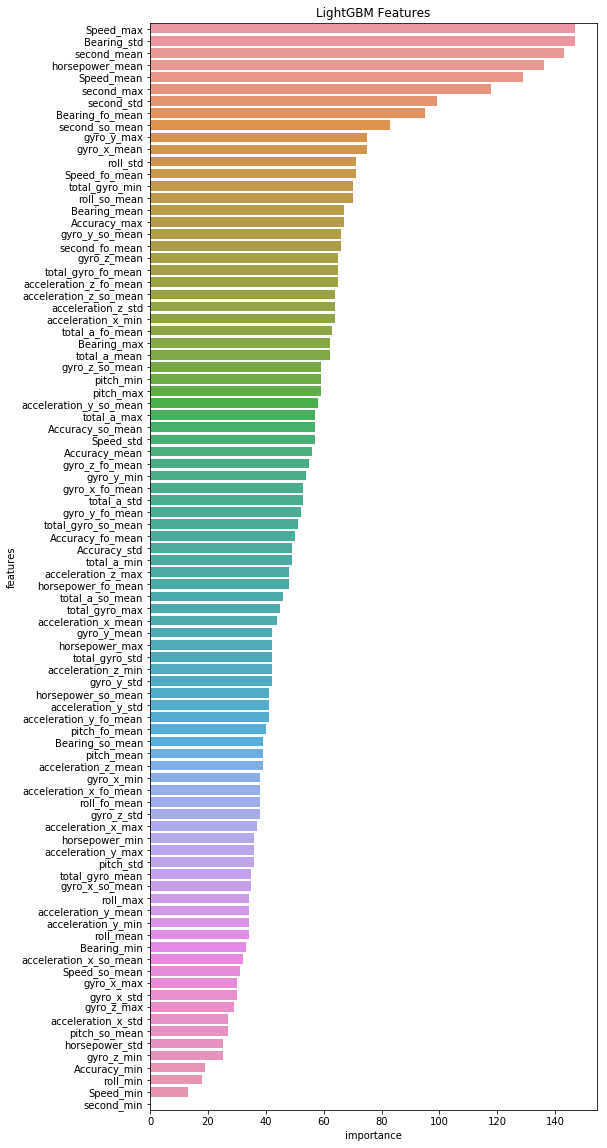

In [14]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

plt.figure(figsize=(8,20))
sns.barplot(x="importance", y="features", 
            data=features_df.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features')
plt.show()